# Imports and Environment

In [2]:
# Basic pandas and numpy
import pandas as pd
import numpy as np

# Statistical analysis libraries
import math
from scipy import stats
from scipy.stats import ttest_rel
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from scipy.stats import normaltest
from scipy.stats import chi2_contingency
 
# Basic visualization tools
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Advanced visualization tools
import plotly as py
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff

# Datetime libraries
import datetime
 
# Pandas defaults
pd.options.display.max_columns = 500
pd.options.display.max_rows = 500

Defining an hypothesis checker function:

In [3]:
# Defining a hypothesis checker function:
def hyp_checker(pvalue):
    pvalue = pvalue.round(2)
    # alpha = float(input("What's your alpha?"))
    alpha = 0.05
    if type(alpha) != float:
        print('Insert a correct alpha')
        return hyp_checker(result)
    else:
        if pvalue <= alpha:
            return "Our p value ({}) is smaller than our alpha ({}). H0 is rejected".format(pvalue, alpha)
        else:
            return "Our p value ({}) is bigger than our alpha ({}). Fail to reject H0".format(pvalue, alpha)

# Dataset Import and EDA

## Importing and subsetting

In [4]:
flights_raw = pd.read_csv('../data/flights/flights.csv')

/home/eiroamd/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning:

Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.



As the dataframe has too many rows (almost 6 millions) I make a copy to work on, so I don't have to load it afterwards if I want to reverse any change:

In [5]:
flights = flights_raw.copy()

Setting a constant of total flights using the length of the initial dataframe to get the proportions later:

In [6]:
TOTAL_FLIGHTS = len(flights)

As I am going to perform the analysis mainly on the flights that have been delayed, I will make a subset.

In [7]:
delayed = flights.loc[flights.ARRIVAL_DELAY > 0]

## Column Explanations

* **YEAR:** Year of the Flight Trip
* **MONTH:** Month of the Flight Trip
* **DAY:** Day of the Flight Trip
* **DAY_OF_WEEK:** Day of week of the Flight Trip
* **AIRLINE:** Airline Identifier
* **FLIGHT_NUMBER:** Flight Identifier
* **TAIL_NUMBER:** Aircraft Identifier
* **ORIGIN_AIRPORT:** Starting Airport
* **DESTINATION_AIRPORT:** Destination Airport
* **SCHEDULED_DEPARTURE:** Planned Departure Time (as integer: first two digits hour, other two digits minutes)
* **DEPARTURE_TIME:** Actual Departure Time
* **DEPARTURE_DELAY:** Total Delay on Departure (in minutes). If + Delayed, if - Before.
* **TAXI_OUT:** The time duration elapsed between departure from the origin airport gate and wheels off
* **WHEELS_OFF:** The time point that the aircraft's wheels leave the ground
* **SCHEDULED_TIME:** Planned time amount needed for the flight trip
* **ELAPSED_TIME:** AIR_TIME+TAXI_IN+TAXI_OUT
* **AIR_TIME:** The time duration between wheels_off and wheels_on time
* **DISTANCE:** Distance between two airports
* **WHEELS_ON:** The time point that the aircraft's wheels touch on the ground
* **TAXI_IN:** The time duration elapsed between wheels-on and gate arrival at the destination airport
* **SCHEDULED_ARRIVAL:** Planned arrival time
* **ARRIVAL_TIME:** WHEELS_ON+TAXI_IN
* **ARRIVAL_DELAY:** ARRIVAL_TIME-SCHEDULED_ARRIVAL. If + Delayed, if - Before.
* **DIVERTED:** Aircraft landed on airport that out of schedule
* **CANCELLED:** Flight Cancelled (1 = cancelled)
* **CANCELLATION_REASON:** Reason for Cancellation of flight: A - Airline/Carrier; B - Weather; C - National Air System; D - Security
* **AIR_SYSTEM_DELAY:** Delay caused by air system
* **SECURITY_DELAY:** Delay caused by security
* **AIRLINE_DELAY:** Delay caused by the airline
* **LATE_AIRCRAFT_DELAY:** Delay caused by aircraft
* **WEATHER_DELAY:** Delay caused by weather

## EDA

In [8]:
delayed.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286.0,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
5,2015,1,1,4,DL,806,N3730B,SFO,MSP,25,20.0,-5.0,18.0,38.0,217.0,230.0,206.0,1589,604.0,6.0,602,610.0,8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
14,2015,1,1,4,DL,2440,N651DL,SEA,MSP,40,39.0,-1.0,28.0,107.0,189.0,198.0,166.0,1399,553.0,4.0,549,557.0,8.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
20,2015,1,1,4,NK,520,N525NK,LAS,MCI,55,120.0,25.0,11.0,131.0,162.0,143.0,128.0,1139,539.0,4.0,537,543.0,6.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
21,2015,1,1,4,AA,371,N3GXAA,SEA,MIA,100,52.0,-8.0,30.0,122.0,338.0,347.0,311.0,2724,933.0,6.0,938,939.0,1.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
print('Dataframe dimensions: {} rows x {} columns'.format(delayed.shape[0], delayed.shape[1]))

Dataframe dimensions: 2086896 rows x 31 columns


### Describing numerical values statistics

In [10]:
descriptive = delayed.describe()[['ARRIVAL_DELAY', 'DEPARTURE_DELAY', 'AIR_TIME', 'ELAPSED_TIME']].T
descriptive['IQR'] = descriptive['75%'] - descriptive['25%']

In [11]:
descriptive

,count,mean,std,min,25%,50%,75%,max,IQR
ARRIVAL_DELAY,2086896.0,33.112990,52.942508,1.0,6.0,15.0,38.0,1971.0,32.0
DEPARTURE_DELAY,2086896.0,30.290374,54.606989,-42.0,0.0,13.0,38.0,1988.0,38.0
AIR_TIME,2086896.0,115.916197,73.711731,7.0,61.0,97.0,147.0,690.0,86.0
ELAPSED_TIME,2086896.0,143.719285,76.123927,15.0,88.0,126.0,177.0,766.0,89.0


### Information of column types and NaN values

Creating a table with type of variable, number of absolute null values (NV) and relative null values (%):

In [12]:
tab_info=pd.DataFrame(delayed.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(delayed.isnull().sum()).T.rename(index={0:'null values (NV)'}))
tab_info=tab_info.append(pd.DataFrame(delayed.isnull().sum()/delayed.shape[0]*100).T.rename(index={0:'null values (%)'}))

In [13]:
tab_info

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
column type,int64,int64,int64,int64,object,int64,object,object,object,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,object,float64,float64,float64,float64,float64
null values (NV),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2086896,1023457,1023457,1023457,1023457,1023457
null values (%),0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,100,49.0421,49.0421,49.0421,49.0421,49.0421


**DESCRIPTION OF THE TYPES OF VARIABLES:**

**CATEGORICAL VARIABLES:**

AIRLINE, FLIGHT_NUMBER, TAIL_NUMBER, ORIGIN_AIRPORT, DESTINATION_AIRPORT, DIVERTED, CANCELLED, CANCELLATION_REASON, AIR_SYSTEM_DELAY, SECURITY_DELAY, AIRLINE_DELAY, LATE_AIRCRAFT_DELAY, WEATHER_DELAY.


**DISCRETE NUMERICAL VARIABLES:**

YEAR, MONTH, DAY, DAY_OF_WEEK, SCHEDULED_DEPARTURE, DEPARTURE_TIME, DISTANCE, SCHEDULED_ARRIVAL.


**CONTINUOUS NUMERICAL VARIABLES:**

TAXI_OUT, WHEELS_OFF, SCHEDULED_TIME, ELAPSED_TIME, AIR_TIME, WHEELS_ON, TAXI_IN, ARRIVAL_TIME, ARRIVAL_DELAY, DEPARTURE_DELAY.

Filtering only those columns that have null values an sorting them by proportion of null values:

In [14]:
tab_info.T.loc[tab_info.T['null values (%)'] != 0].sort_values(by='null values (%)', ascending=False)

,column type,null values (NV),null values (%)
CANCELLATION_REASON,object,2086896,100
AIR_SYSTEM_DELAY,float64,1023457,49.0421
SECURITY_DELAY,float64,1023457,49.0421
AIRLINE_DELAY,float64,1023457,49.0421
LATE_AIRCRAFT_DELAY,float64,1023457,49.0421
WEATHER_DELAY,float64,1023457,49.0421


### Distribution plotting

The distribution for both arrival and departure delay times is plotted, using both a distribution plot and a boxplot

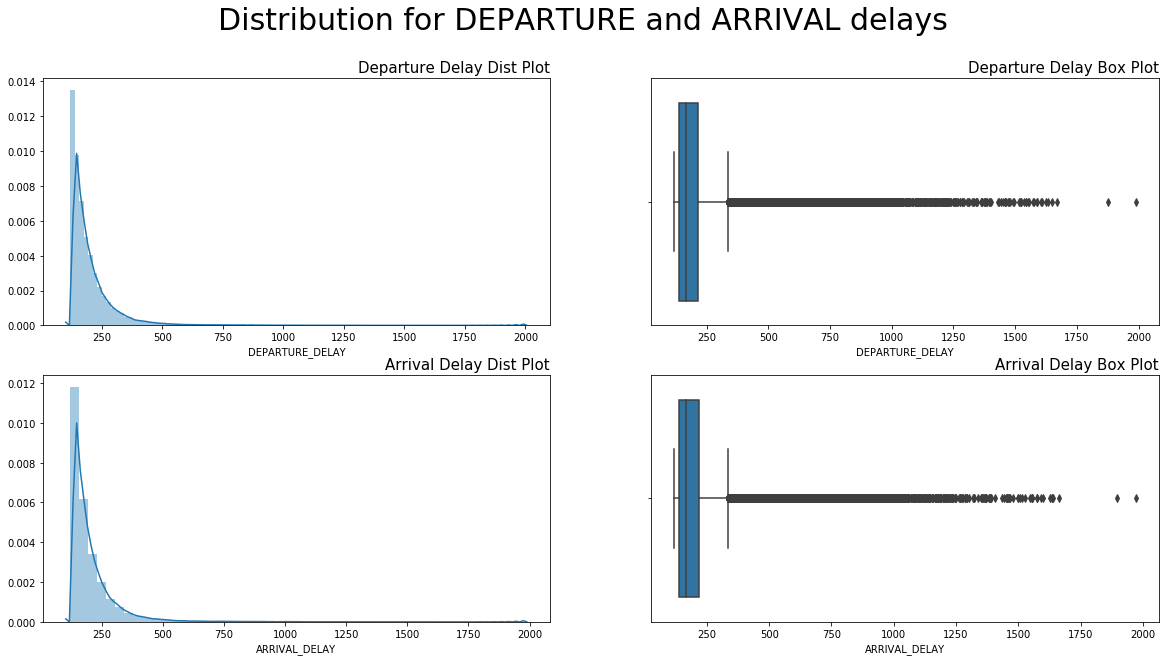

In [15]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(20,10))
fig.suptitle('Distribution for DEPARTURE and ARRIVAL delays', fontsize=30, fontweight=300)

plt.sca(ax1)
#  Dataset and tags:
x1 = delayed.DEPARTURE_DELAY.dropna().loc[delayed.DEPARTURE_DELAY >=120]
ax1.set_title('Departure Delay Dist Plot', loc='right', fontsize=15, fontweight=300)
# Create plot:
sns.distplot(x1, bins=100)


plt.sca(ax2)
#  Dataset and tags:
x2 = delayed.DEPARTURE_DELAY.dropna().loc[delayed.DEPARTURE_DELAY >=120]
ax2.set_title('Departure Delay Box Plot', loc='right', fontsize=15, fontweight=300)
# Create plot:
sns.boxplot(x2)


plt.sca(ax3)
#  Dataset and tags:
x3 = delayed.ARRIVAL_DELAY.dropna().loc[delayed.ARRIVAL_DELAY >=120]
ax3.set_title('Arrival Delay Dist Plot', loc='right', fontsize=15, fontweight=300)
# Create plot:
sns.distplot(x3)


plt.sca(ax4)
#  Dataset and tags:
x4 = delayed.ARRIVAL_DELAY.dropna().loc[delayed.ARRIVAL_DELAY >=120]
ax4.set_title('Arrival Delay Box Plot', loc='right', fontsize=15, fontweight=300)
# Create plot:
sns.boxplot(x4)

plt.show()

As observed, there are a lot of upper outliers. Most of the observations are concentrated on the lower part of the distribution (i.e. most of the delays are short), with high variability for delays longer than 250 min (approx 4h).

### Correlations

I plot a heatmap to spot the different correlations:

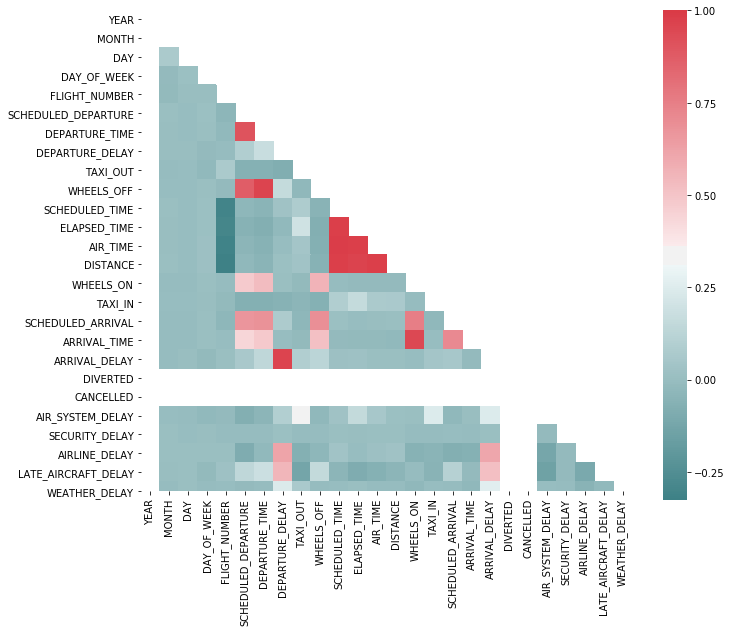

In [16]:
cormat = delayed.corr()

# Setting the mask for the upper half:
mask = np.zeros_like(cormat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Setting up the figure:
f, ax = plt.subplots(figsize=(11, 9))

# Creating colormap:
cmap = sns.diverging_palette(200, 10, as_cmap=True)

# Plotting the heatmap:
sns.heatmap(cormat, cmap=cmap, square=True, mask=mask)

#### Interpretation

**STRONG POSITIVE CORRELATIONS:** Elapsed time and distance, scheduled time and distance, and elapsed time and scheduled time.

**SOMEWHAT POSITIVE CORRELATIONS:** Departure and arrival delay and airline and late aircraft delay (which are to of the recorded delay reasons.

**SOMEWHAT NEGATIVE CORRELATIONS:** Scheduled time, elapsed time and distance with flight number. These correlations seem to be spurious.

## Data Cleaning

### Dropping unnecesary columns

As there are many entries where I don't have the delay reasons, and to lighten the weight of the dataset, I will drop those entries. Also, I will drop the 'CANCELLATION_REASON' column, as it is empty.

There are many columns that I won't be using for analysis, so I also drop them:

'TAXI_OUT', 'WHEELS_OFF', 'AIR_TIME', 'WHEELS_ON', 'TAXI_IN': Are subdivisions of 'ELAPSED_TIME' that I won't be using.

'CANCELLED' does not apply in this specific subset.

'DIVERTED' is composed only of 0

In [17]:
delayed = delayed.loc[(delayed.AIR_SYSTEM_DELAY.notna()) | 
                      (delayed.SECURITY_DELAY.notna()) |
                      (delayed.AIRLINE_DELAY.notna()) |
                      (delayed.LATE_AIRCRAFT_DELAY.notna()) |
                      (delayed.WEATHER_DELAY.notna())].drop(['CANCELLED', 'CANCELLATION_REASON',
                                                             'DIVERTED',
                                                             'TAXI_OUT', 'WHEELS_OFF', 'AIR_TIME', 
                                                             'WHEELS_ON', 'TAXI_IN'], axis=1)

In [18]:
print('Dataframe dimensions are now: {} rows x {} columns'.format(delayed.shape[0], delayed.shape[1]))

Dataframe dimensions are now: 1063439 rows x 23 columns


### Dealing with outliers (arrival delays)

Although I don't agree that dropping the outliers in this particular setting would be really beneficial in terms of a better performance of a theoretical future model based on this data (I want to discuss this with the TAs when correction time comes, as my starting point is to analyse the long delays, which are actually the ones among the outliers), I clean the outliers for practising purposes.

In [19]:
q75, q25 = np.percentile(delayed.ARRIVAL_DELAY.dropna().loc[delayed.ARRIVAL_DELAY >=120], [75, 25])
iqr = q75 - q25
low = q25 - (iqr*1.5)
high = q75 + (iqr*1.5)

Subsetting to select only those between the range:

In [20]:
delayed = delayed.loc[(delayed.ARRIVAL_DELAY > low) & (delayed.ARRIVAL_DELAY < high)]

Plotting the distribution after outlier removal:

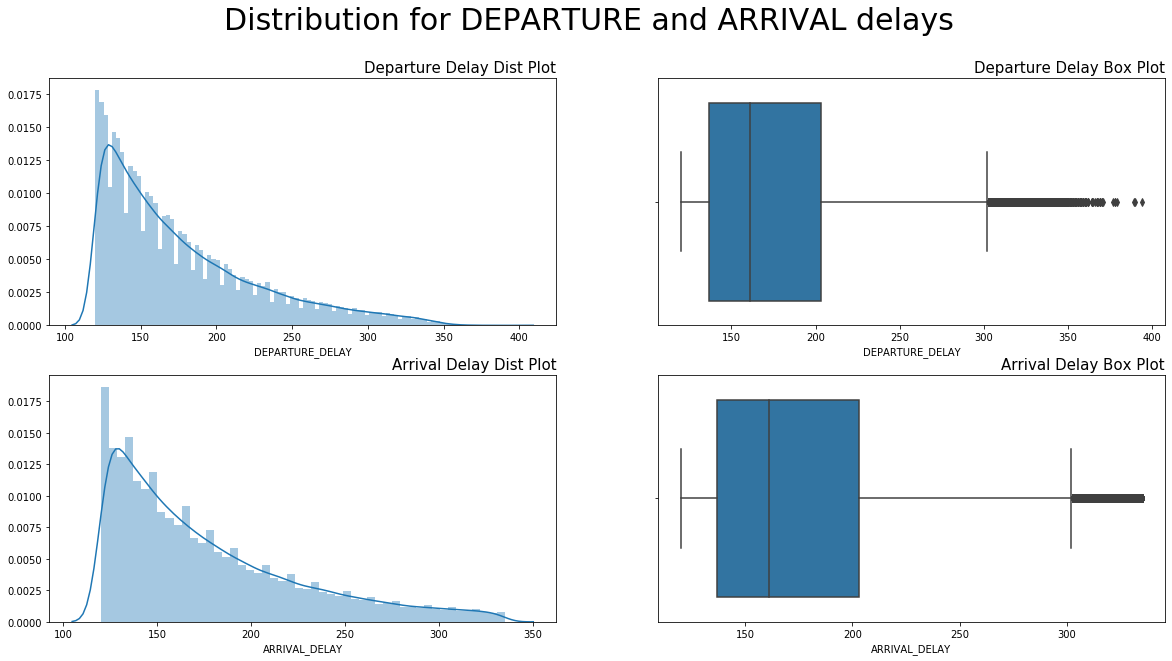

In [21]:
fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(20,10))
fig.suptitle('Distribution for DEPARTURE and ARRIVAL delays', fontsize=30, fontweight=300)

plt.sca(ax1)
#  Dataset and tags:
x1 = delayed.DEPARTURE_DELAY.dropna().loc[delayed.DEPARTURE_DELAY >=120]
ax1.set_title('Departure Delay Dist Plot', loc='right', fontsize=15, fontweight=300)
# Create plot:
sns.distplot(x1, bins=100)


plt.sca(ax2)
#  Dataset and tags:
x2 = delayed.DEPARTURE_DELAY.dropna().loc[delayed.DEPARTURE_DELAY >=120]
ax2.set_title('Departure Delay Box Plot', loc='right', fontsize=15, fontweight=300)
# Create plot:
sns.boxplot(x2)


plt.sca(ax3)
#  Dataset and tags:
x3 = delayed.ARRIVAL_DELAY.dropna().loc[delayed.ARRIVAL_DELAY >=120]
ax3.set_title('Arrival Delay Dist Plot', loc='right', fontsize=15, fontweight=300)
# Create plot:
sns.distplot(x3)


plt.sca(ax4)
#  Dataset and tags:
x4 = delayed.ARRIVAL_DELAY.dropna().loc[delayed.ARRIVAL_DELAY >=120]
ax4.set_title('Arrival Delay Box Plot', loc='right', fontsize=15, fontweight=300)
# Create plot:
sns.boxplot(x4)

plt.show()

We can see a normal-like distribution, skewed to the right with way less outliers than before.

In [22]:
print('Dataframe dimensions are now: {} rows x {} columns'.format(delayed.shape[0], delayed.shape[1]))

Dataframe dimensions are now: 878371 rows x 23 columns


## Data Manipulation 

### Dates and Times

In [23]:
delayed.head(2)

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,ELAPSED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
27,2015,1,1,4,NK,597,N528NK,MSP,FLL,115,127.0,12.0,207.0,220.0,1487,542,607.0,25.0,25.0,0.0,0.0,0.0,0.0
30,2015,1,1,4,NK,168,N629NK,PHX,ORD,125,237.0,72.0,204.0,175.0,1440,549,632.0,43.0,43.0,0.0,0.0,0.0,0.0


The formatting of dates and times in the dataset are a mess, so I try to concentrate the date into a single DateTime column and give 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'SCHEDULED_DEPARTURE' and 'DEPARTURE_TIME' the same format and converting them to DateTime type.

In [24]:
delayed['DATE'] = pd.to_datetime(delayed[['YEAR', 'MONTH', 'DAY']], infer_datetime_format=True)

In [25]:
delayed = delayed.drop(['YEAR', 'MONTH', 'DAY'], axis=1)

In [26]:
# Defining the formatting function:
def hour_format(hour):
    if hour == 2400:
        hour = 0
    hour = float(hour)
    hour = "{0:04d}".format(int(hour)) # Giving all the entries the same format (4 digits)
    hour = datetime.time(int(hour[:2]), int(hour[2:])) # First two digits are the hour and second two the minutes
    return hour

# Changing column values for the new formatted ones:
for i in ['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME']:
    delayed[i] = delayed[i].apply(hour_format)

### Reordering columns

In [27]:
cols = ['DATE', 'DAY_OF_WEEK', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER',
       'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'SCHEDULED_DEPARTURE',
       'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'SCHEDULED_TIME', 'ELAPSED_TIME',
       'DISTANCE', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
       'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY',
       'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
delayed = delayed[cols]

In [28]:
print('Dataframe dimensions are now: {} rows x {} columns'.format(delayed.shape[0], delayed.shape[1]))

Dataframe dimensions are now: 878371 rows x 21 columns


As the resulting dataframe still contains too many rows, and bearing in mind that this notebook is for demonstration purposes, a filter using the TOP 30 airports by volume of passenger in the US will be set:

In [29]:
top30 = ['ATL', 'LAX', 'ORD', 'DFW', 'DEN', 'JFK', 'SFO', 'SEA', 'LAS', 'MCO',
         'EWR', 'CLT', 'PHX', 'IAH', 'MIA', 'BOS', 'MSP', 'FLL', 'DTW', 'PHL',
         'LGW', 'BWI', 'SLC', 'SAN', 'IAD', 'DCA', 'MDW', 'TPA', 'PDX', 'HNL']

In [30]:
delayed = delayed.loc[(delayed.ORIGIN_AIRPORT.isin(top30)) & (delayed.DESTINATION_AIRPORT.isin(top30))]

In [31]:
print('Dataframe dimensions are now: {} rows x {} columns'.format(delayed.shape[0], delayed.shape[1]))

Dataframe dimensions are now: 324562 rows x 21 columns


## Confidence Intervals

### Statistics about departure and arrival delays by **AIRLINE**

Defining a function to get the IQR for every group:

In [32]:
def iqr(array):
    return array.quantile(.75) - array.quantile(.25)

def quant25(array):
    return array.quantile(.25)

def median(array):
    return array.quantile(.5)

def quant75(array):
    return array.quantile(.75)

In [33]:
functions = [np.mean, np.std, np.min, np.max, quant75, median, quant25, iqr]

Grouping:

In [34]:
airlines = delayed[['AIRLINE', 
                    'DEPARTURE_DELAY', 
                    'ARRIVAL_DELAY']].groupby('AIRLINE', as_index=False).agg(functions)

In [35]:
airlines.head()

DEPARTURE_DELAY                                                        \
                   mean        std  amin   amax quant75 median quant25    iqr   
AIRLINE                                                                         
AA            56.661319  55.751065 -24.0  369.0   77.00   43.0    19.0  58.00   
AS            48.548184  50.474044 -19.0  369.0   65.00   37.0    16.0  49.00   
B6            61.825801  58.675436 -17.0  394.0   84.00   46.0    22.0  62.00   
DL            58.452052  58.985407 -15.0  364.0   78.00   42.0    20.0  58.00   
EV            60.447809  58.797970 -13.0  345.0   82.25   45.0    21.0  61.25   

        ARRIVAL_DELAY                                                       
                 mean        std  amin   amax quant75 median quant25   iqr  
AIRLINE                                                                     
AA          62.404476  50.661942  20.0  335.0    77.0   44.0    29.0  48.0  
AS          55.772745  44.878467  20.0  335.0    66.0   40.0    27.0  39.0  
B6          67.679425  54.020824  20.0  335.0    85.0   48.0    30.0  55.0  
DL          63.591376  54.109757  20.0  335.0    77.0   43.0    28.0  49.0  
EV          67.797809  54.634316  20.0  334.0    85.0   47.0    30.0  55.0

**Filtering the top 5 airlines by mean departure and arrival delay:**

Top 5 airlines by **departure** delay:

In [36]:
top5_airlines_dep_del = airlines['DEPARTURE_DELAY']['mean'].sort_values(ascending=False).head(5)
top5_airlines_dep_del

AIRLINE
UA    68.732780
NK    63.258268
B6    61.825801
EV    60.447809
WN    58.654488
Name: mean, dtype: float64

Top 5 airlines by **arrival** delay:

In [37]:
top5_airlines_arr_del = airlines['ARRIVAL_DELAY']['mean'].sort_values(ascending=False).head(5)
top5_airlines_arr_del

AIRLINE
MQ    70.181566
NK    69.548456
UA    68.508364
EV    67.797809
B6    67.679425
Name: mean, dtype: float64

#### Confidence intervals

I build 95% confidence intervals for the global mean and the mean of the Top5 airlines by arrival and departure delay:

**Global:**

In [38]:
# Departure delays statistics:
global_dep_del_mean = delayed.DEPARTURE_DELAY.mean()
global_dep_del_std = np.std(delayed.DEPARTURE_DELAY)

# Arrival statistics:
global_arr_del_mean = delayed.ARRIVAL_DELAY.mean()
global_arr_del_std = np.std(delayed.ARRIVAL_DELAY)

# General statistics:
t = stats.t.interval(0.95, ((len(delayed))-1))[1]

# Construction of both limits of the Departure delays interval:
dep_del_low = (global_dep_del_mean - t*(global_dep_del_std/math.sqrt(len(delayed)))).round(2)
dep_del_high = (global_dep_del_mean + t*(global_dep_del_std/math.sqrt(len(delayed)))).round(2)

# Construction of both limits of the Arrival delays interval:
arr_del_low = (global_arr_del_mean - t*(global_arr_del_std/math.sqrt(len(delayed)))).round(2)
arr_del_high = (global_arr_del_mean + t*(global_arr_del_std/math.sqrt(len(delayed)))).round(2)

In [39]:
# Construction and printing of the intervals:
ci_dep = (dep_del_low, dep_del_high)
ci_arr = (arr_del_low, arr_del_high)

print('·Interpretation:') 
print('The mean departure delay expected amongst all delayed flights is between {} and {} minutes with a 95% confidence.'.format(ci_dep[0], ci_dep[1]))
print('The mean arrival delay expected amongst all delayed flights is between {} and {} minutes with a 95% confidence.'.format(ci_arr[0], ci_arr[1]))

·Interpretation:
The mean departure delay expected amongst all delayed flights is between 59.32 and 59.71 minutes with a 95% confidence.
The mean arrival delay expected amongst all delayed flights is between 63.62 and 63.97 minutes with a 95% confidence.


**TOP5 by Departure Delay:**

In [40]:
for i in list(top5_airlines_dep_del.index):
    # Subsetting
    subset = delayed['DEPARTURE_DELAY'].loc[delayed.AIRLINE == i]
    
    # Statistics
    mean = subset.mean()
    std = np.std(subset)
    t = stats.t.interval(0.95, ((len(subset))-1))[1]
    
    # Construction
    low = (mean - t*(std/math.sqrt(len(subset)))).round(2)
    high = (mean + t*(std/math.sqrt(len(subset)))).round(2)
    
    # Interpretation
    print('The mean Departure delay expected amongst {} delayed flights is between {} and {} minutes with a 95% confidence.'.format(i, low, high))

The mean Departure delay expected amongst UA delayed flights is between 68.25 and 69.21 minutes with a 95% confidence.
The mean Departure delay expected amongst NK delayed flights is between 62.42 and 64.09 minutes with a 95% confidence.
The mean Departure delay expected amongst B6 delayed flights is between 61.03 and 62.63 minutes with a 95% confidence.
The mean Departure delay expected amongst EV delayed flights is between 58.82 and 62.07 minutes with a 95% confidence.
The mean Departure delay expected amongst WN delayed flights is between 58.22 and 59.09 minutes with a 95% confidence.


**TOP5 by Arrival Delay:**

In [41]:
for i in list(top5_airlines_arr_del.index):
    # Subsetting
    subset = delayed['ARRIVAL_DELAY'].loc[delayed.AIRLINE == i]
    
    # Statistics
    mean = subset.mean()
    std = np.std(subset)
    t = stats.t.interval(0.95, ((len(subset))-1))[1]
    
    # Construction
    low = (mean - t*(std/math.sqrt(len(subset)))).round(2)
    high = (mean + t*(std/math.sqrt(len(subset)))).round(2)
    
    # Interpretation
    print('The mean Arrival delay expected amongst {} delayed flights is between {} and {} minutes with a 95% confidence.'.format(i, low, high))

The mean Arrival delay expected amongst MQ delayed flights is between 67.82 and 72.55 minutes with a 95% confidence.
The mean Arrival delay expected amongst NK delayed flights is between 68.77 and 70.33 minutes with a 95% confidence.
The mean Arrival delay expected amongst UA delayed flights is between 68.07 and 68.95 minutes with a 95% confidence.
The mean Arrival delay expected amongst EV delayed flights is between 66.29 and 69.31 minutes with a 95% confidence.
The mean Arrival delay expected amongst B6 delayed flights is between 66.94 and 68.42 minutes with a 95% confidence.


### Statistics about departure and arrival delays by **AIRPORT**

#### Grouping by origin airport

In [42]:
origin_airports = delayed[['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 
                           'DEPARTURE_DELAY', 'ARRIVAL_DELAY']].groupby('ORIGIN_AIRPORT', 
                                                                        as_index=False).agg(functions)

In [43]:
origin_airports.head()

DEPARTURE_DELAY                                                 \
                          mean        std  amin   amax quant75 median quant25   
ORIGIN_AIRPORT                                                                  
ATL                  59.767893  55.465281 -24.0  364.0    78.0   44.0    25.0   
BOS                  55.262823  56.895532 -18.0  355.0    76.0   41.0    16.0   
BWI                  60.808169  58.520514 -19.0  345.0    80.0   44.0    24.0   
CLT                  50.441314  51.559268 -13.0  354.0    69.0   37.0    16.0   
DCA                  57.647403  60.317297 -14.0  351.0    79.0   41.0    16.0   

                     ARRIVAL_DELAY                                         \
                 iqr          mean        std  amin   amax quant75 median   
ORIGIN_AIRPORT                                                              
ATL             53.0     63.009971  51.691317  20.0  335.0    78.0   43.0   
BOS             60.0     63.651767  51.818535  20.0  333.0    78.0   44.0   
BWI             56.0     65.712385  55.004324  20.0  334.0    82.0   44.0   
CLT             53.0     58.759464  47.258389  20.0  334.0    72.0   42.0   
DCA             63.0     67.795294  55.909144  20.0  334.0    86.0   46.0   

                               
               quant25    iqr  
ORIGIN_AIRPORT                 
ATL              28.00  50.00  
BOS              29.00  49.00  
BWI              29.00  53.00  
CLT              28.00  44.00  
DCA              29.25  56.75

Filtering the top 3 destination airports by mean departure delay:

In [44]:
top3_airports_dep_del = origin_airports['DEPARTURE_DELAY']['mean'].sort_values(ascending=False).head(3)
top3_airports_dep_del

ORIGIN_AIRPORT
EWR    68.116406
ORD    66.678689
MCO    66.054318
Name: mean, dtype: float64

Confidence intervals by origin airport for TOP3 Airports:

In [45]:
for i in list(top3_airports_dep_del.index):
    # Subsetting
    subset = delayed['DEPARTURE_DELAY'].loc[delayed.ORIGIN_AIRPORT == i]
    
    # Statistics
    mean = subset.mean()
    std = np.std(subset)
    t = stats.t.interval(0.95, ((len(subset))-1))[1]
    
    # Construction
    low = (mean - t*(std/math.sqrt(len(subset)))).round(2)
    high = (mean + t*(std/math.sqrt(len(subset)))).round(2)
    
    # Interpretation
    print('The mean Departure delay expected amongst {} delayed flights is between {} and {} minutes with a 95% confidence.'.format(i, low, high))

The mean Departure delay expected amongst EWR delayed flights is between 66.99 and 69.25 minutes with a 95% confidence.
The mean Departure delay expected amongst ORD delayed flights is between 65.94 and 67.42 minutes with a 95% confidence.
The mean Departure delay expected amongst MCO delayed flights is between 64.96 and 67.15 minutes with a 95% confidence.


#### Grouping by destination airport

In [46]:
destination_airports = delayed[['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 
                                'DEPARTURE_DELAY', 'ARRIVAL_DELAY']].groupby('DESTINATION_AIRPORT', 
                                                                             as_index=False).agg(functions)

In [47]:
destination_airports.head()

DEPARTURE_DELAY                                         \
                               mean        std  amin   amax quant75 median   
DESTINATION_AIRPORT                                                          
ATL                       61.340936  59.694673 -17.0  364.0    82.0   45.0   
BOS                       60.577304  55.125461 -17.0  394.0    81.0   46.0   
BWI                       61.313465  54.079711 -11.0  339.0    80.0   46.0   
CLT                       49.793270  53.684914 -14.0  355.0    68.0   37.0   
DCA                       55.739243  53.454933 -14.0  337.0    75.0   43.0   

                                  ARRIVAL_DELAY                          \
                    quant25   iqr          mean        std  amin   amax   
DESTINATION_AIRPORT                                                       
ATL                    22.0  60.0     66.094260  55.440039  20.0  335.0   
BOS                    25.0  56.0     64.679975  50.813266  20.0  335.0   
BWI                    27.0  53.0     62.718675  49.936541  20.0  335.0   
CLT                    13.0  55.0     59.051510  49.765834  20.0  334.0   
DCA                    21.0  54.0     62.332864  49.104488  20.0  335.0   

                                                   
                    quant75 median quant25    iqr  
DESTINATION_AIRPORT                                
ATL                   82.00   45.0    29.0  53.00  
BOS                   81.00   46.0    30.0  51.00  
BWI                   78.00   44.0    28.0  50.00  
CLT                   72.75   39.0    27.0  45.75  
DCA                   77.00   45.0    29.0  48.00

Filtering the top 3 destination airports by mean arrival delay:

In [48]:
top3_airports_arr_del = destination_airports['ARRIVAL_DELAY']['mean'].sort_values(ascending=False).head(3)
top3_airports_arr_del

DESTINATION_AIRPORT
JFK    72.913930
EWR    70.549163
ORD    68.867452
Name: mean, dtype: float64

Confidence intervals by destination airport for TOP3 Airports:

In [49]:
for i in list(top3_airports_arr_del.index):
    # Subsetting
    subset = delayed['DEPARTURE_DELAY'].loc[delayed.DESTINATION_AIRPORT == i]
    
    # Statistics
    mean = subset.mean()
    std = np.std(subset)
    t = stats.t.interval(0.95, ((len(subset))-1))[1]
    
    # Construction
    low = (mean - t*(std/math.sqrt(len(subset)))).round(2)
    high = (mean + t*(std/math.sqrt(len(subset)))).round(2)
    
    # Interpretation
    print('The mean Departure delay expected amongst {} delayed flights is between {} and {} minutes with a 95% confidence.'.format(i, low, high))

The mean Departure delay expected amongst JFK delayed flights is between 67.84 and 70.11 minutes with a 95% confidence.
The mean Departure delay expected amongst EWR delayed flights is between 68.18 and 70.34 minutes with a 95% confidence.
The mean Departure delay expected amongst ORD delayed flights is between 60.15 and 61.76 minutes with a 95% confidence.


### Proportion of long delay flights among all flights

In [50]:
long_delay = (((len(flights['ARRIVAL_DELAY'].loc[flights['ARRIVAL_DELAY'] >= 120])) / TOTAL_FLIGHTS) * 100)
print('The proportion of flights delayed over 2h among all flights is {0:.2f}%'.format(long_delay))

The proportion of flights delayed over 2h among all flights is 2.00%


#### Confidence interval

In [51]:
# Variables 
score_99 = stats.norm.interval(0.99)[1];

# Parameters
prop = ((len(flights['ARRIVAL_DELAY'].loc[flights['ARRIVAL_DELAY'] >= 120])) / TOTAL_FLIGHTS)
eep = math.sqrt(((prop * (1 - prop)) / TOTAL_FLIGHTS))

# Confidence interval
number = score_99*eep
low = ((prop - number)*100).round(2)
high = ((prop + number)*100).round(2)

# Output:
print('The expected proportion of delayed flights for longer than 2h is between {}% and {}% with a 99% confidence.'.format(low, high))

The expected proportion of delayed flights for longer than 2h is between 1.98% and 2.01% with a 99% confidence.


### Proportion of long delay flights among all the flights of #1 company in terms of number of flights

In [52]:
top1_airline = flights.AIRLINE.value_counts().index[0]

In [54]:
total_top1_flights = len(flights.AIRLINE.loc[flights.AIRLINE == top1_airline])
delayed_top1_flights = len(flights.AIRLINE.loc[(flights.AIRLINE == top1_airline
                                             ) & (flights.ARRIVAL_DELAY >= 120)])
prop_del_airline = (delayed_top1_flights / total_top1_flights)*100

In [55]:
print('The proportion of flights delayed over 2h among all WN flights is {0:.2f} %'.format(prop_del_airline))

The proportion of flights delayed over 2h among all WN flights is 1.59 %


#### Confidence interval

In [59]:
# Variables 
score_99 = stats.norm.interval(0.99)[1];

# Parameters
prop = (prop_del_airline )/ 100
eep = math.sqrt(((prop * (1 - prop)) / total_top1_flights))

# Confidence interval
number = score_99*eep
low = ((prop - number)*100).round(2)
high = ((prop + number)*100).round(2)

# Output:
print('The expected proportion of delayed flights for longer than 2h for WN is between {}% and {}% with a 99% confidence.'.format(low, high))

The expected proportion of delayed flights for longer than 2h for WN is between 1.56% and 1.62% with a 99% confidence.


### Proportion of long delay **ORIGIN** flights in the #1 Airport in terms of number of total departures

In [60]:
top1_airport = flights.ORIGIN_AIRPORT.value_counts().index[0]

In [63]:
total_top1_airport_flights = len(flights.ORIGIN_AIRPORT.loc[flights.ORIGIN_AIRPORT == top1_airport])
delayed_top1_airport_flights = len(flights.ORIGIN_AIRPORT.loc[(flights.ORIGIN_AIRPORT == top1_airport
                                                              ) & (flights.DEPARTURE_DELAY >=120)])
prop_del_dep_airport = (delayed_top1_airport_flights / total_top1_airport_flights)*100
prop_del_dep_airport = round(prop_del_dep_airport, 2)

In [64]:
print('The proportion of departures delayed over 2h among all {} flights is {} %'.format(top1_airport, prop_del_dep_airport))

The proportion of departures delayed over 2h among all ATL flights is 1.73 %


#### Confidence interval

In [65]:
# Variables 
score_99 = stats.norm.interval(0.99)[1];

# Parameters
prop = prop_del_dep_airport / 100
eep = math.sqrt(((prop * (1 - prop)) / total_top1_airport_flights))

# Confidence interval
number = score_99*eep
low = ((prop - number)*100).round(2)
high = ((prop + number)*100).round(2)

# Output:
print('The expected proportion of delayed departures for longer than 2h in ATL airport is between {}% and {}% with a 99% confidence.'.format(low, high))

The expected proportion of delayed departures for longer than 2h in ATL airport is between 1.67% and 1.79% with a 99% confidence.


### Proportion of long delay **DESTINATION** flights in the #1 Airport in terms of number of total arrivals

In [66]:
top1_airport = flights.DESTINATION_AIRPORT.value_counts().index[0]

In [67]:
total_top1_airport_flights = len(flights.DESTINATION_AIRPORT.loc[flights.DESTINATION_AIRPORT == top1_airport])
delayed_top1_airport_flights = len(flights.DESTINATION_AIRPORT.loc[(flights.DESTINATION_AIRPORT == top1_airport
                                                              ) & (flights.DEPARTURE_DELAY >=120)])
prop_del_arr_airport = (delayed_top1_airport_flights / total_top1_airport_flights)*100
prop_del_arr_airport = round(prop_del_arr_airport,2)

In [68]:
print('The proportion of arrivals delayed over 2h among all {} flights is {} %'.format(top1_airport, prop_del_arr_airport))

The proportion of arrivals delayed over 2h among all ATL flights is 2.09 %


#### Confidence intervals

In [69]:
# Variables 
score_99 = stats.norm.interval(0.99)[1];

# Parameters
prop = prop_del_arr_airport / 100
eep = math.sqrt(((prop * (1 - prop)) / total_top1_airport_flights))

# Confidence interval
number = score_99*eep
low = ((prop - number)*100).round(2)
high = ((prop + number)*100).round(2)

# Output:
print('The expected proportion of delayed departures for longer than 2h in {} airport is between {}% and {}% with a 99% confidence.'.format(top1_airport, low, high))

The expected proportion of delayed departures for longer than 2h in ATL airport is between 2.03% and 2.15% with a 99% confidence.


## Hypothesis Testing

### Is there a significant correlation between mean departure and arrival delay for those flights delayed longer than 2h in the TOP30 US airports?

I use a two sample matched pairs T test (same flights for departure and arrival) to try to demonstrate a significant correlation between mean departure and arrival delays for those flights departing late from the top 30 airports which suffer an arrival delay equal or longer than 2h.

**H0:** mean departure delay = mean arrival delay

**H1:** mean departure delay != mean arrival delay

In [70]:
departure = delayed.DEPARTURE_DELAY.loc[delayed.ARRIVAL_DELAY >= 120]
arrival = delayed.ARRIVAL_DELAY.loc[delayed.ARRIVAL_DELAY >= 120]

In [71]:
result = ttest_rel(departure, arrival)
hyp_checker(result[1])

'Our p value (0.0) is smaller than our alpha (0.05). H0 is rejected'

We cannot demonstrate that there is a significant correlation between mean departure and arrival delays.

### Are arrival delays on weekends (Fri-Sat-Sun) significantly different from those on weekdays (Mon-Tue-Wed-Thu) for flights delayed in the TOP30 US airports?

#### Total delays:

**H0:** There are no differences in arrival delays between weekdays and weekends.

**H1:** There are differences in arrival delays between weekdays and weekends.

In [72]:
weekdays = [1, 2, 3, 4]
weekends = [5, 6, 7]

week = delayed.ARRIVAL_DELAY.loc[delayed.DAY_OF_WEEK.isin(weekdays)]
weekend = delayed.ARRIVAL_DELAY.loc[delayed.DAY_OF_WEEK.isin(weekends)]

In [73]:
result = ttest_ind(week, weekend, equal_var=False)
result

Ttest_indResult(statistic=7.718407129525227, pvalue=1.181896006059053e-14)

In [74]:
hyp_checker(result[1])

'Our p value (0.0) is smaller than our alpha (0.05). H0 is rejected'

We cannot conclude that there are no differences in arrival delays between weekend and weekdays.

#### Long delays:

**H0:** There are no differences in arrival delays between weekdays and weekends.

**H1:** There are differences in arrival delays between weekdays and weekends.

In [75]:
week = delayed.ARRIVAL_DELAY.loc[(delayed.DAY_OF_WEEK.isin(weekdays)) & (delayed.ARRIVAL_DELAY >= 120)]
weekend = delayed.ARRIVAL_DELAY.loc[(delayed.DAY_OF_WEEK.isin(weekends)) & (delayed.ARRIVAL_DELAY >= 120)]

In [76]:
result = ttest_ind(week, weekend, equal_var=False)
result

Ttest_indResult(statistic=-0.17010782336501282, pvalue=0.8649264264793952)

In [77]:
hyp_checker(result[1])

'Our p value (0.86) is bigger than our alpha (0.05). Fail to reject H0'

H0 cannot be rejected, so we cannot conclude that there are differences in long arrival delays between weekdays and weekends.

### Are there differences between variances on the arrival delay for the TOP5 airlines? 

**H0:** all groups have the same population mean.

**H1:** at least one mean differs.

In [78]:
"""

# Printing out the different groups in order to assign them to the ANOVA function:
print("result = stats.kruskal(")
for i in list(flights.AIRLINE.value_counts().index):
    print("flights.ARRIVAL_DELAY.loc[flights.AIRLINE == '{}'].dropna(),".format(i))

"""

'\n\n# Printing out the different groups in order to assign them to the ANOVA function:\nprint("result = stats.kruskal(")\nfor i in list(flights.AIRLINE.value_counts().index):\n    print("flights.ARRIVAL_DELAY.loc[flights.AIRLINE == \'{}\'].dropna(),".format(i))\n\n'

In [79]:
# Testing normality of the distributions:
normaltest(flights.ARRIVAL_DELAY.loc[flights.AIRLINE == 'EV'].dropna())

NormaltestResult(statistic=555862.929242624, pvalue=0.0)

The distribution of the groups is not normal, as demonstrated by the normal test performed over the different groups, so I have to use a non-parametric test. Kruskal Wallis is the one chosen, given the characteristics of my variables. 

In [80]:
result = stats.kruskal(flights.ARRIVAL_DELAY.loc[flights.AIRLINE == 'WN'].dropna(),
                      flights.ARRIVAL_DELAY.loc[flights.AIRLINE == 'DL'].dropna(),
                      flights.ARRIVAL_DELAY.loc[flights.AIRLINE == 'AA'].dropna(),
                      flights.ARRIVAL_DELAY.loc[flights.AIRLINE == 'OO'].dropna(),
                      flights.ARRIVAL_DELAY.loc[flights.AIRLINE == 'EV'].dropna())

result

KruskalResult(statistic=47196.68302365132, pvalue=0.0)

In [81]:
hyp_checker(result[1])

'Our p value (0.0) is smaller than our alpha (0.05). H0 is rejected'

We cannot conclude that there are no differences between the groups.

### Are there differences between variances on the arrival delay for the TOP30 airports? 

**H0:** all groups have the same population mean.

**H1:** at least one mean differs.

In [82]:
# Printing out the different groups in order to assign them to the ANOVA function:
"""
printº("result = f_oneway(")
for i in list(top30):
    x = delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == i].dropna()
    if len(x) != 0:
        print("delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == '{}'].dropna(),".format(i))
"""

'\nprintº("result = f_oneway(")\nfor i in list(top30):\n    x = delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == i].dropna()\n    if len(x) != 0:\n        print("delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == \'{}\'].dropna(),".format(i))\n'

In [83]:
# Testing normality of the distributions:
normaltest(delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'SFO'])

NormaltestResult(statistic=8063.500064773714, pvalue=0.0)

The distribution of the groups is not normal, as demonstrated by the normal test performed over the different groups, so I have to use a non-parametric test. Kruskal Wallis is the one chosen, given the characteristics of my variables. 

In [84]:
result = stats.kruskal(delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'ATL'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'LAX'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'ORD'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'DFW'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'DEN'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'JFK'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'SFO'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'SEA'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'LAS'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'MCO'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'EWR'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'CLT'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'PHX'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'IAH'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'MIA'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'BOS'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'MSP'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'FLL'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'DTW'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'PHL'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'BWI'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'SLC'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'SAN'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'IAD'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'DCA'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'MDW'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'TPA'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'PDX'].dropna(),
                      delayed.ARRIVAL_DELAY.loc[delayed.DESTINATION_AIRPORT == 'HNL'].dropna())
result

KruskalResult(statistic=1790.6349397739154, pvalue=0.0)

In [85]:
hyp_checker(result[1])

'Our p value (0.0) is smaller than our alpha (0.05). H0 is rejected'

We cannot conclude that there are no differences between the groups.

### Is the difference of mean arrival delay significant between #1 and #2 airlines for those flights delayed longer than 2h?

**H0:** There are no significant differences between both airlines (ẍ1 = ẍ2)

**H1:** There are significant differences between both airlines (ẍ1 != ẍ2)

In [86]:
top1 = delayed['ARRIVAL_DELAY'].loc[(delayed.AIRLINE == top5_airlines_arr_del.index[0])
                                    & (delayed.ARRIVAL_DELAY >= 120)]
top2 = delayed['ARRIVAL_DELAY'].loc[(delayed.AIRLINE == top5_airlines_arr_del.index[1])
                                    & (delayed.ARRIVAL_DELAY >= 120)]

In [87]:
result = ttest_ind(top1, top2, equal_var=False)
result

Ttest_indResult(statistic=-2.524217444440517, pvalue=0.012035638919787796)

In [88]:
hyp_checker(result[1])

'Our p value (0.01) is smaller than our alpha (0.05). H0 is rejected'

H0 is rejected, so differences must be statistically significant

### Is there a significant difference on the porportion of long delay flight among all flights between the #1 airport and the rest of airports?

**H0:** There are no significant differences on proportion of long delays between the top1 airport and the rest (%1 = %2)

**H1:** There are significant differences on proportion of long delays between the top1 airport and the rest (%1 != %2)

The adequate test to demonstrate significant differences between **proportions** for independent samples would be a Chi-squared test

In [89]:
# Firstly, I build the contingency table:
conting = pd.crosstab(flights['DESTINATION_AIRPORT'] == top1_airport, flights['ARRIVAL_DELAY'] >= 120)
conting

ARRIVAL_DELAY,False,True
DESTINATION_AIRPORT,,
False,5363071,109104
True,339752,7152


In [90]:
# Then I run the test and get the statitics
result = chi2_contingency(conting)
result

(7.6402043049562645,
 0.005708145156142308,
 1,
 array([[5362849.59355682,  109325.40644318],
        [ 339973.40644318,    6930.59355682]]))

In [91]:
hyp_checker(result[1])

'Our p value (0.01) is smaller than our alpha (0.05). H0 is rejected'

There are significant differences on proportion of long delays between the two top airports (%1 != %2)